# Import libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.impute import SimpleImputer, KNNImputer
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import  train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, f1_score, recall_score, precision_score, accuracy_score, ConfusionMatrixDisplay, make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA


# Load and explore dataset

In [34]:
df = pd.read_csv("loan_data_set.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [37]:
df.Credit_History.value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

In [26]:
df.Loan_Amount_Term.value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

In [38]:
# Load_ID is not an informative feature, so we should drop it
df.drop(columns = ["Loan_ID"], inplace = True)

In [39]:
# Correct data type of `Loan_Amount_Term` and `Credit_History` features
df = df.astype({"Loan_Amount_Term": "object", "Credit_History": "object"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    object 
 9   Credit_History     564 non-null    object 
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 57.7+ KB


In [40]:
# Create two lists for saving names of categorical and continuous columns
cat_vars =[]
num_vars =[]
for c in df.columns:
    if df[c].dtype == "float64" or df[c].dtype == "int64":
        num_vars.append(c)
    else:
        cat_vars.append(c)

print(cat_vars)
print(num_vars)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [41]:
print("The numbers of categorical features:",len(cat_vars))
print("The number of continuos variables:", len(num_vars))

The numbers of categorical features: 9
The number of continuos variables: 3


In [42]:
for c in cat_vars:
    print(df[c].value_counts())
    print("-"*20)


Gender
Male      489
Female    112
Name: count, dtype: int64
--------------------
Married
Yes    398
No     213
Name: count, dtype: int64
--------------------
Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64
--------------------
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64
--------------------
Self_Employed
No     500
Yes     82
Name: count, dtype: int64
--------------------
Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64
--------------------
Credit_History
1.0    475
0.0     89
Name: count, dtype: int64
--------------------
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64
--------------------
Loan_Status
Y    422
N    192
Name: count, dtype: int64
--------------------


In [49]:
# Ratio of frequency of class "Y" to clas "N" in target feature

print("The ratio of frequency of class Y to frequency of class N :", len(df[df["Loan_Status"] =="Y"])/len(df[df["Loan_Status"]=='N']))

print("The percentage of each class Y and N:")
df["Loan_Status"].value_counts()/df.shape[0]

The ratio of frequency of class Y to frequency of class N : 2.1979166666666665
The percentage of each class Y and N:


Loan_Status
Y    0.687296
N    0.312704
Name: count, dtype: float64

In [48]:
# Stastisics of the continuous variables
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,85.587325
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


In [88]:
df.Property_Area.value_counts()

Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64

In [50]:
# Update datatype
dependets_order = pd.CategoricalDtype(["0","1","2","3+"], ordered = True)
df['Dependents'] = df["Dependents"].astype(dependets_order)

term_order = pd.CategoricalDtype([12.0, 36.0, 60.0, 84.0, 120.0, 240.0, 300.0, 360.0, 480.0], ordered = True)
df["Loan_Amount_Term"]= df["Loan_Amount_Term"].astype(term_order)

area_order = pd.CategoricalDtype(["Rural", "Semiurban", "Urban"], ordered= True)
df["Property_Area"]= df["Property_Area"].astype(area_order)



In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             601 non-null    object  
 1   Married            611 non-null    object  
 2   Dependents         599 non-null    category
 3   Education          614 non-null    object  
 4   Self_Employed      582 non-null    object  
 5   ApplicantIncome    614 non-null    int64   
 6   CoapplicantIncome  614 non-null    float64 
 7   LoanAmount         592 non-null    float64 
 8   Loan_Amount_Term   556 non-null    category
 9   Credit_History     564 non-null    object  
 10  Property_Area      614 non-null    category
 11  Loan_Status        614 non-null    object  
dtypes: category(3), float64(2), int64(1), object(6)
memory usage: 45.8+ KB


# Visualization

In the following we provide the following illustrations:

1. *Loan Status Distribution by Categorical Variables:*
In this plot, we visualize the distribution of each categorical feature (excluding the target feature Loan Status) and how its classes are distributed across each class of the target. This type of visualization helps in understanding the relationship between the categorical features and the target feature. It reveals how different values of features like Gender, Married, or Education correlate with the loan approval (Loan_Status).

2. *Mean of Continuous Variables by Loan Status:*
This set of plots showcases the distribution of continuous variables across different categories of the target feature Loan Status. For example, the ApplicantIncome feature shows a right-skewed distribution, where most values are clustered around lower income levels (near 50,000) but with a few outliers with much higher incomes. These plots provide insight into the skewness and spread of the data, helping us understand the variance and potential outliers.

3. *Cumulative Distribution of Continuous Variables by Loan Status with Percentile Markers:*
Given the skewness observed in the continuous features, we plot the cumulative distribution function (CDF) to capture the proportion of data below a certain value for each variable. We also include percentile markers (e.g., quartiles) to better understand the distribution. This plot is useful for visualizing how data is distributed across the target feature categories and helps guide decisions like transforming continuous variables into categorical ones by grouping values based on quantiles.

4. *Distribution of Log Transform of Continuous Variables:*
Given the skewness of continuous features, we visualize the distribution of log-transformed of continuous variables using kernel density estimation (KDE) plots. The aim is to use this transformation in data preprocessing step.

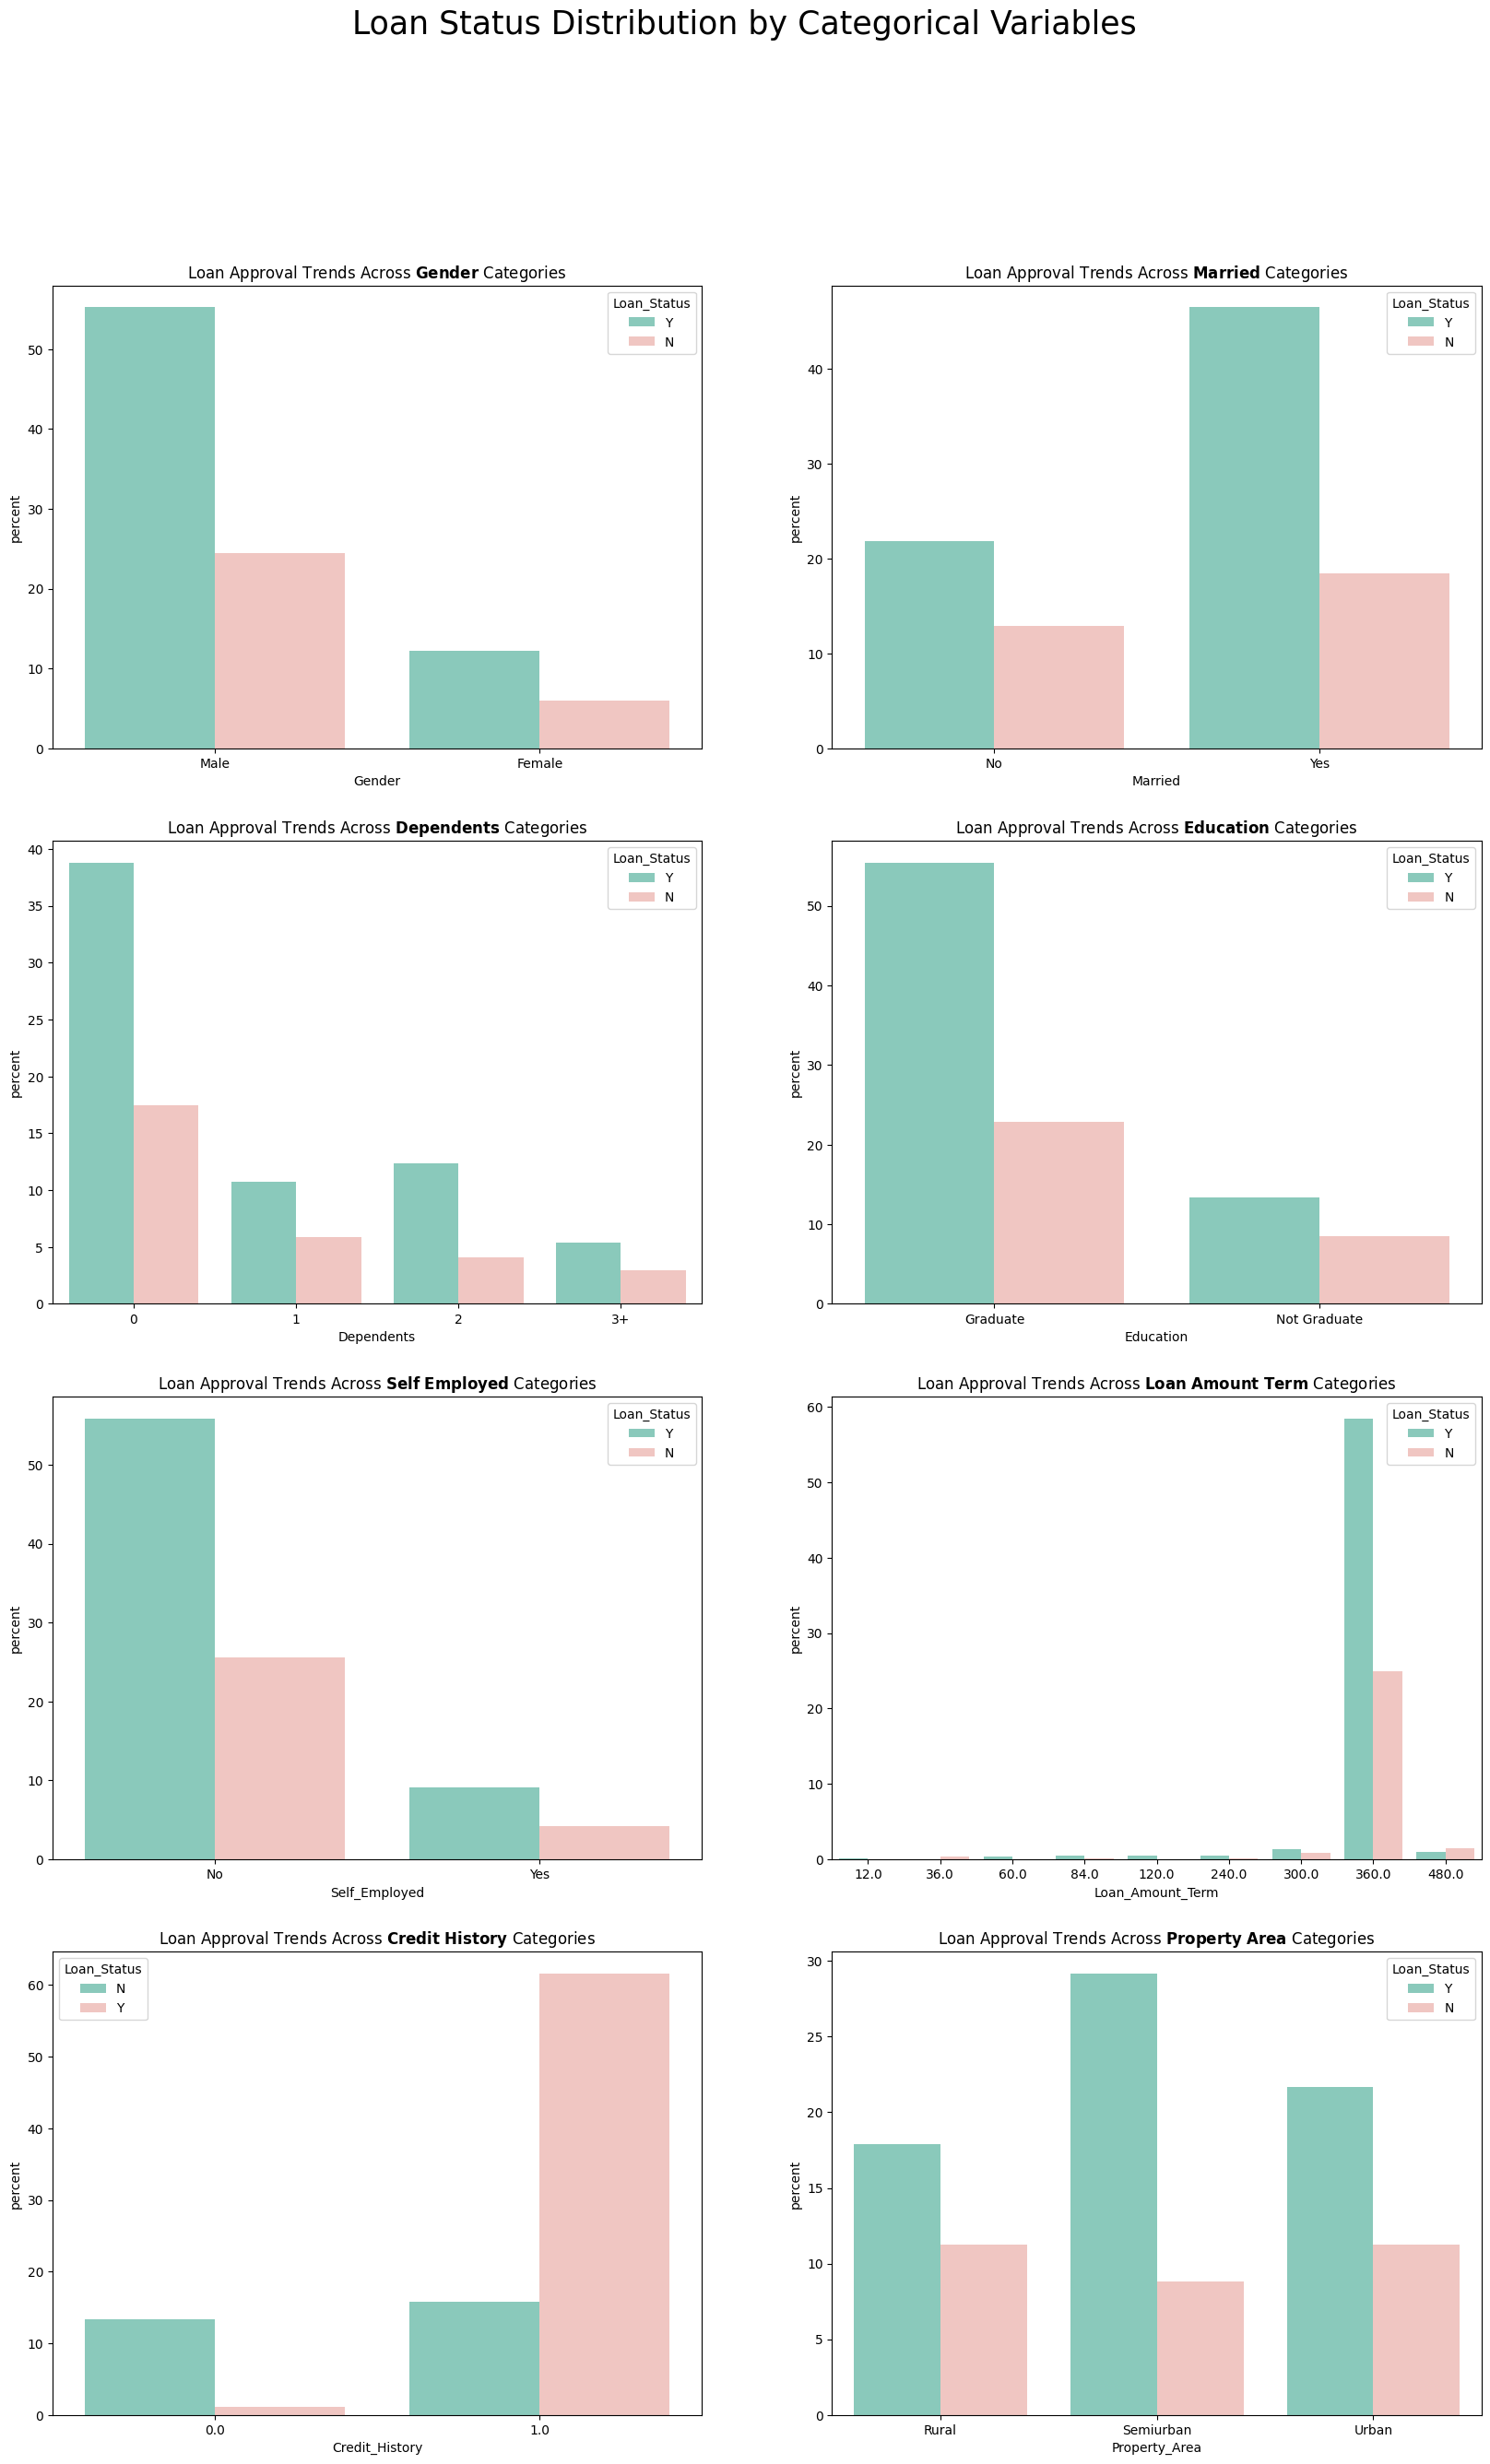

In [92]:
fig,ax = plt.subplots(4,2, figsize = (20,30))
fig.suptitle("Loan Status Distribution by Categorical Variables", fontsize = 25)
custom_palette = ['#7FD4C1','#F7C0BB',]#'#4CAF50', '#FF5722']

for i, cat_feature in enumerate(cat_vars[:-1]):
    sns.countplot(data = df , x = cat_feature, hue = "Loan_Status", stat = "percent", ax = ax[i//2, i%2], color = 'group', palette=custom_palette)
    cat_feature = cat_feature.replace('_', '\\ ')
    ax[i//2,i%2].set_title(f"Loan Approval Trends Across $\\bf{{{cat_feature}}}$ Categories" , fontsize=12, fontweight='normal')


C:\Users\solmaz\AppData\Local\Temp\ipykernel_19336\1970870958.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Loan_Status", y=feature, ax=ax[i//2, i%2], palette=custom_palette)
C:\Users\solmaz\AppData\Local\Temp\ipykernel_19336\1970870958.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Loan_Status", y=feature, ax=ax[i//2, i%2], palette=custom_palette)
C:\Users\solmaz\AppData\Local\Temp\ipykernel_19336\1970870958.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Loan_Status", y=feature, ax=ax[i//2

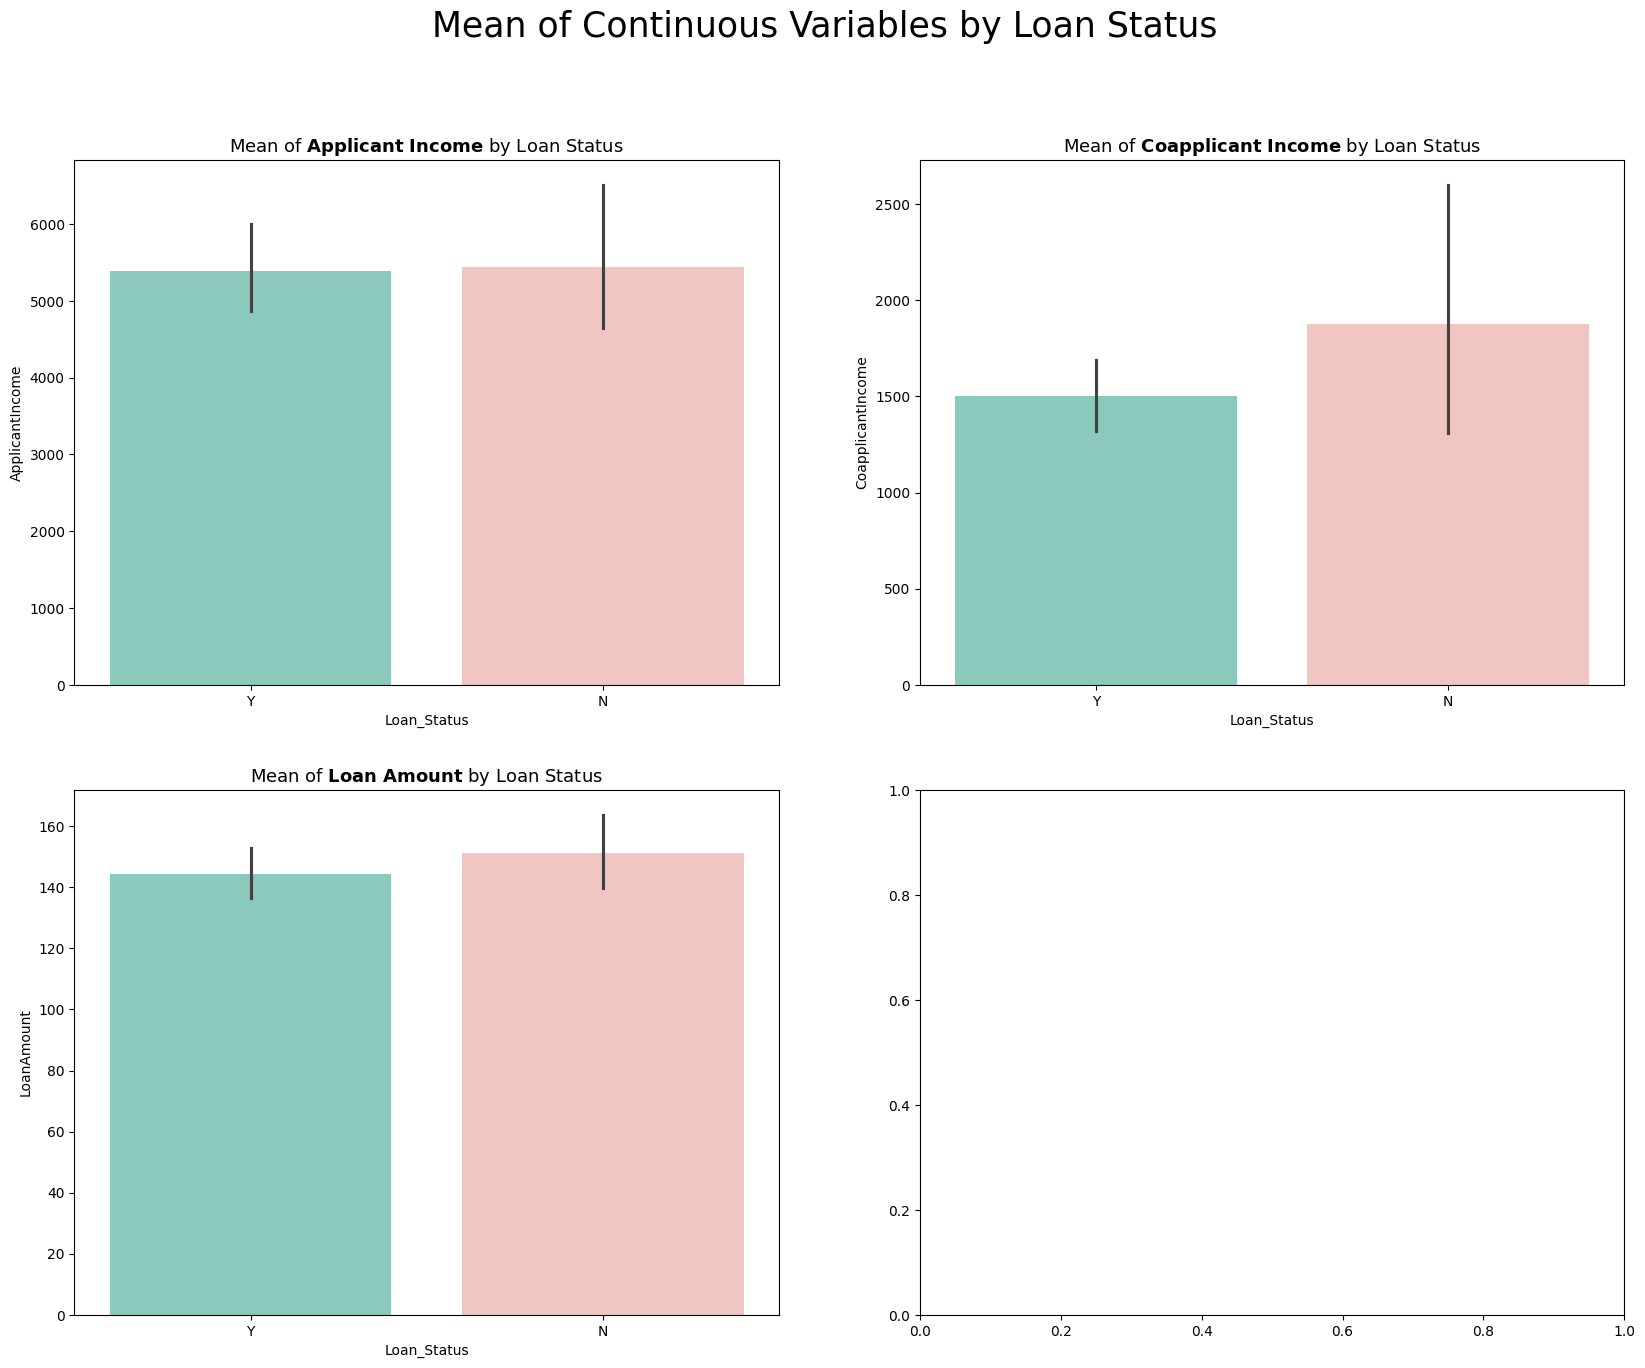

In [93]:

custom_palette = ['#7FD4C1','#F7C0BB'] 

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("Mean of Continuous Variables by Loan Status", fontsize=25)

for i, feature in enumerate(num_vars):
    sns.barplot(data=df, x="Loan_Status", y=feature, ax=ax[i//2, i%2], palette=custom_palette)
    
    feature = re.sub(r'(?<!^)(?=[A-Z])', '\\ ', feature)
    feature = feature.replace('_', ' ')
    
    ax[i//2, i%2].set_title(f"Mean of $\\bf{{{feature}}}$ by Loan Status", fontsize=13)


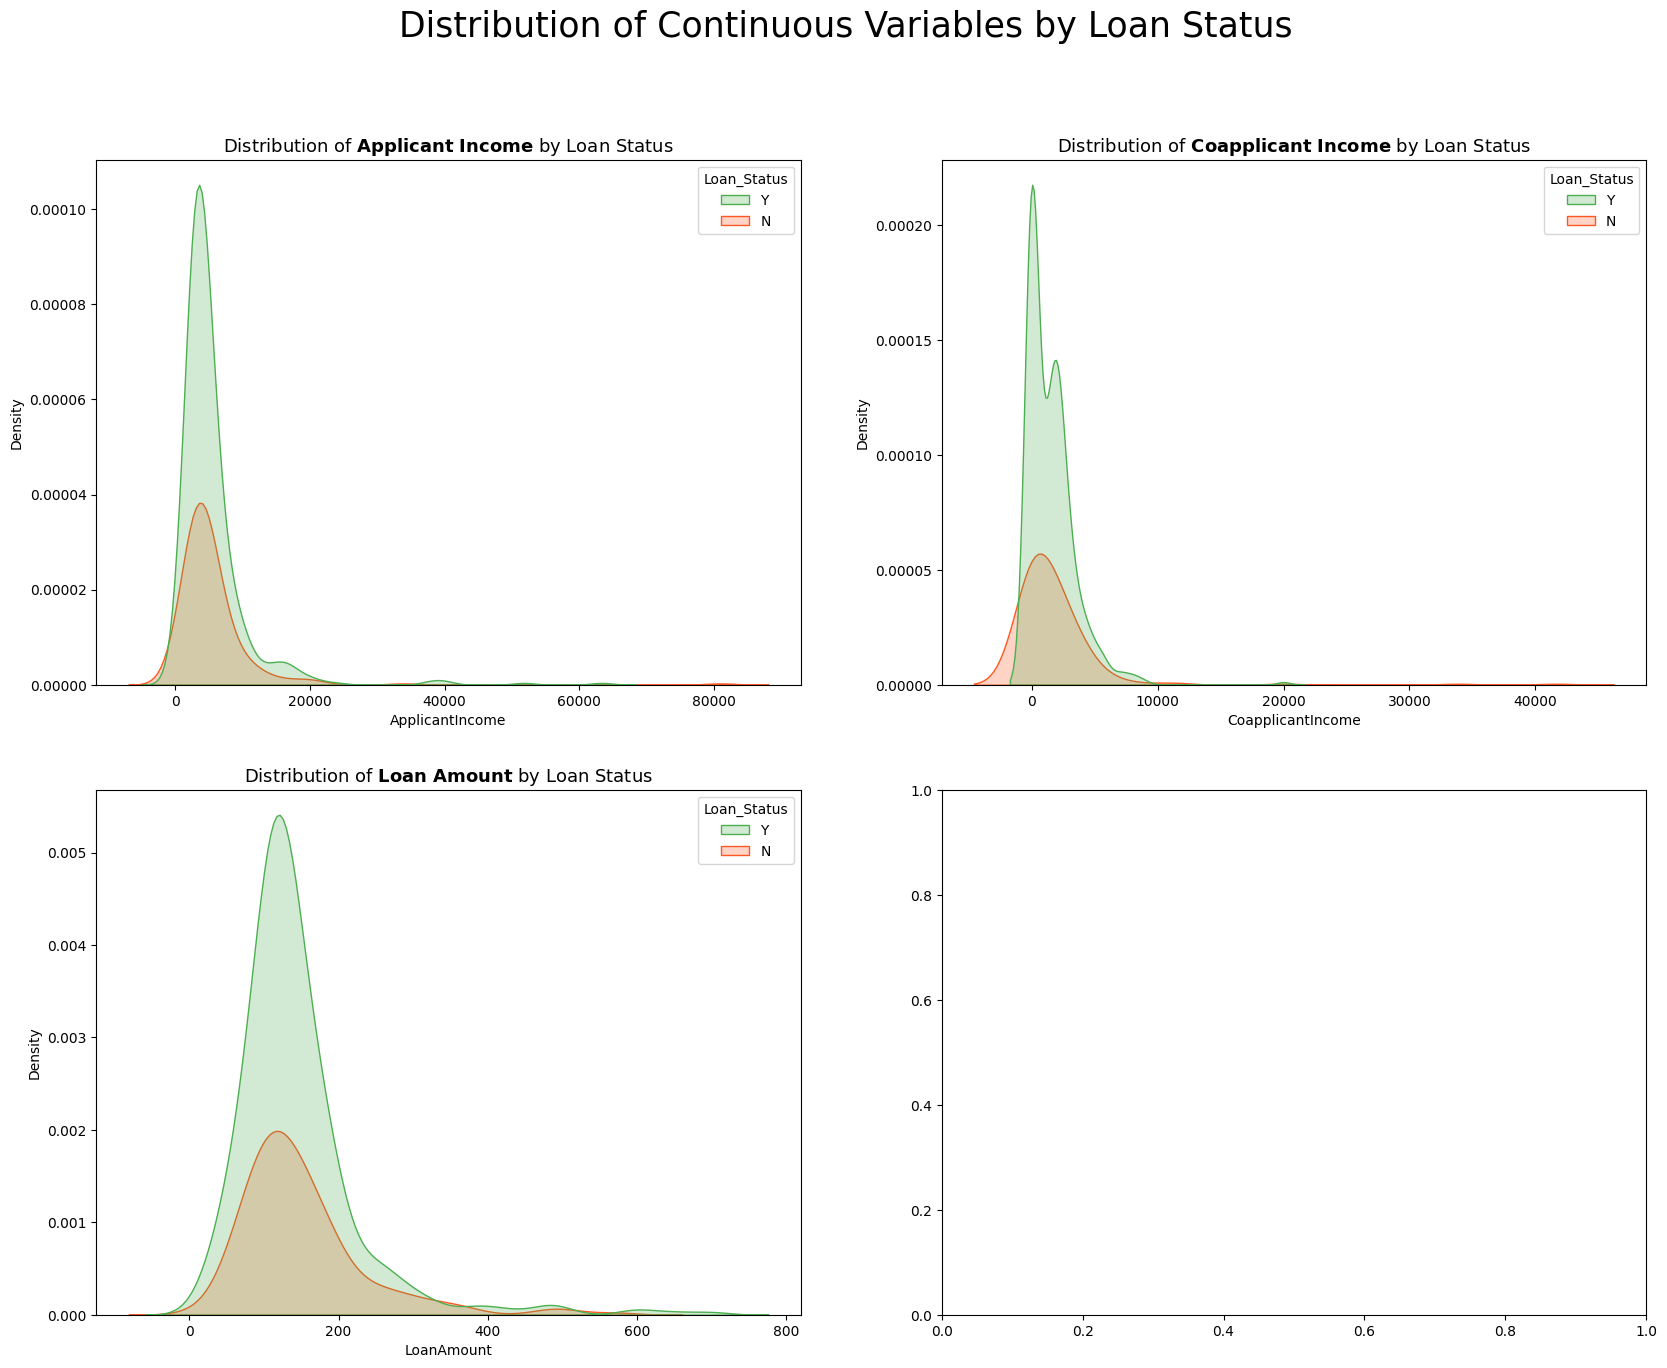

In [94]:
custom_palette = ['#4CAF50', '#FF5722']  # 'A': '#7FD4C1', 'B': '#30BFDD', 'C': '#8690FF', 'E': '#F7C0BB'

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("Distribution of Continuous Variables by Loan Status", fontsize=25)

for i, feature in enumerate(num_vars):
    sns.kdeplot(data=df, hue="Loan_Status",fill= True, x=feature, ax=ax[i//2, i%2], palette=custom_palette)
    
    feature = re.sub(r'(?<!^)(?=[A-Z])', '\\ ', feature)
    feature = feature.replace('_', ' ')
    
    ax[i//2, i%2].set_title(f"Distribution of $\\bf{{{feature}}}$ by Loan Status", fontsize=13)

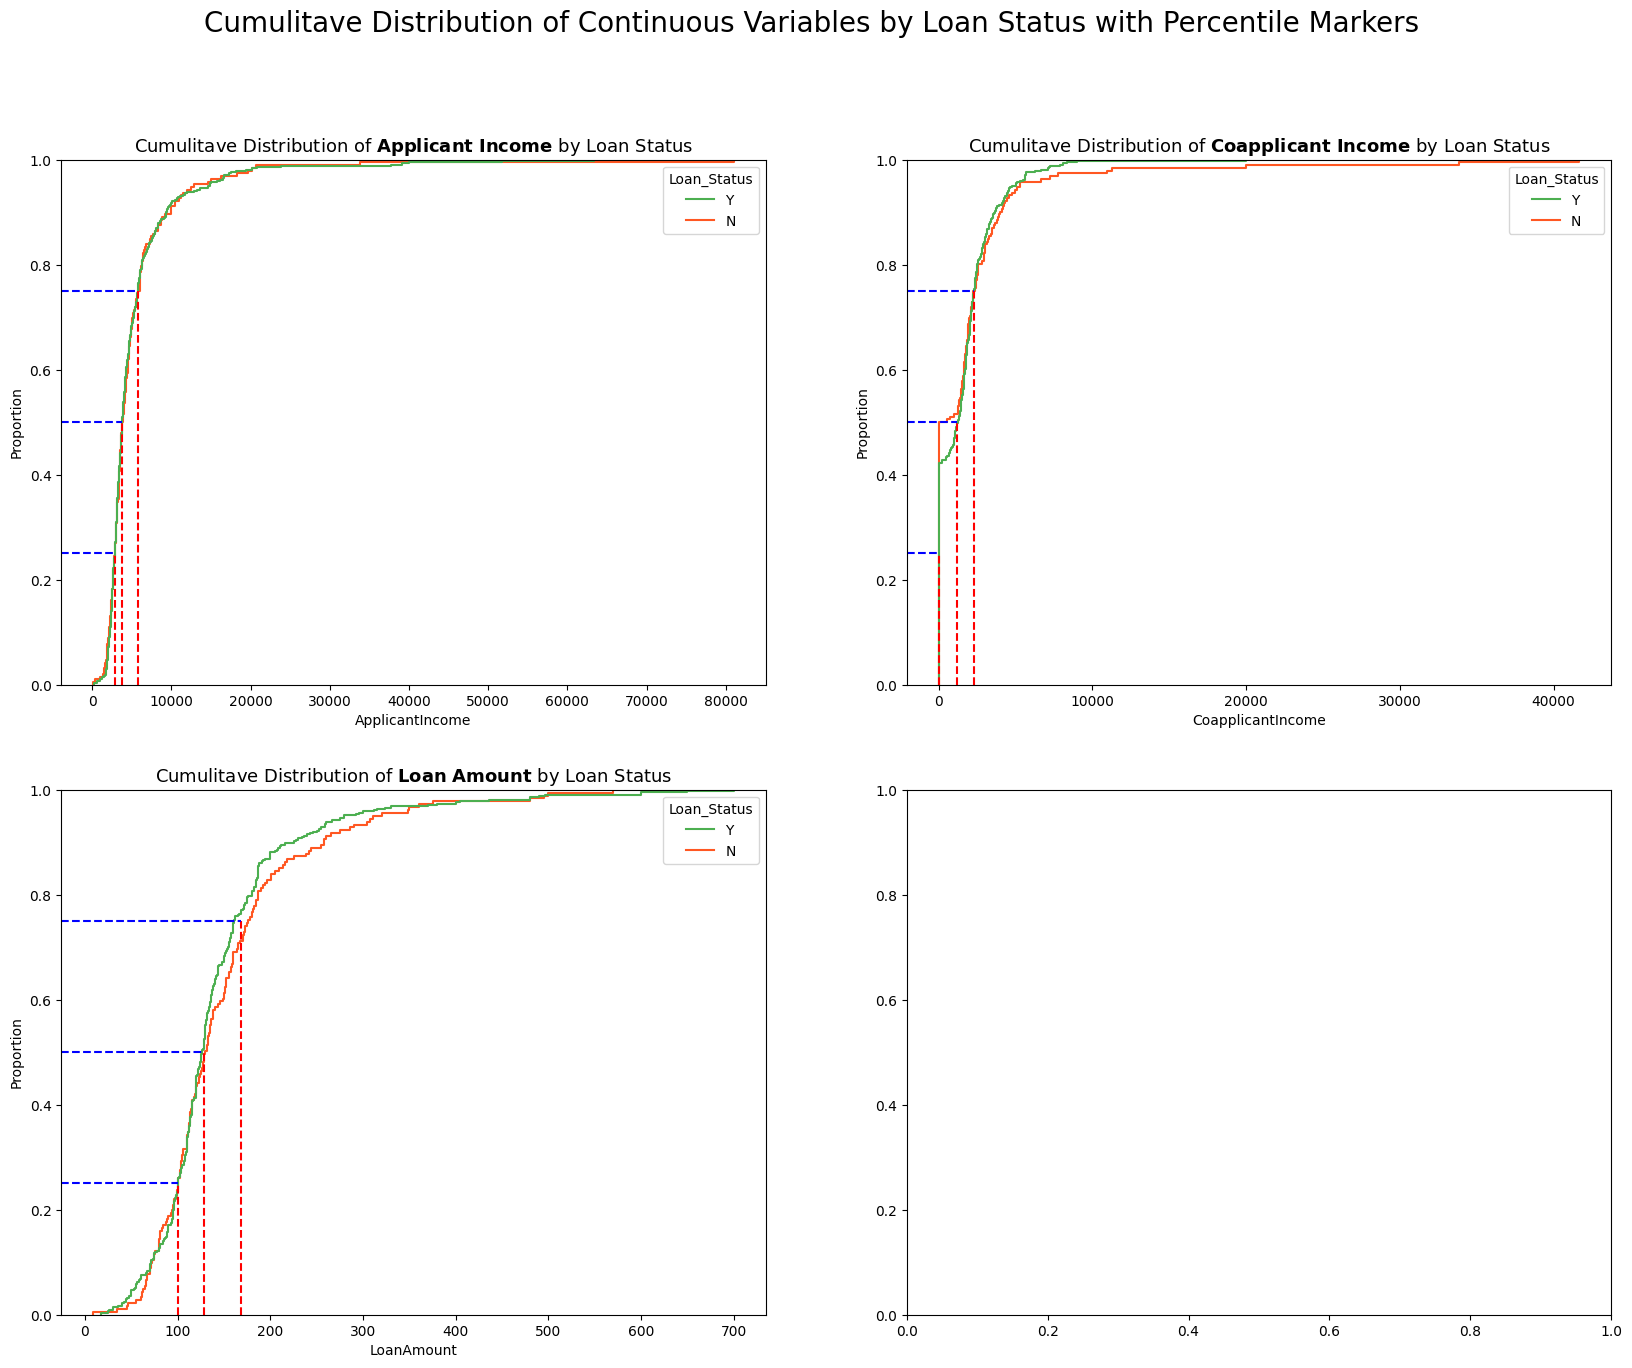

In [96]:
custom_palette = ['#4CAF50', '#FF5722']  

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("Cumulitave Distribution of Continuous Variables by Loan Status with Percentile Markers", fontsize=20)

for i, feature in enumerate(num_vars):
    sns.ecdfplot(data=df, hue="Loan_Status", x=feature, ax=ax[i//2, i%2], palette=custom_palette)

    percentiles_values = df[feature].quantile([.25,.5,.75]).values #np.percentile(df[feature], [25, 50, 75], )
    percentiles = [0.25, 0.50, 0.75]
    #print(percentiles_values)
    x_min, x_max = ax[i//2, i%2].get_xlim()

    # Plot vertical and horizontal lines at 25th, 50th, and 75th percentiles
    for value, perc in zip(percentiles_values, percentiles):

        ax[i//2, i%2].axvline(x=value, ymin=0, ymax=perc, linestyle='--', color='red' )
        
        normalized_value = (value - x_min) / (x_max - x_min) # Convert the data value to axis coordinates for the horizontal line
        # Normalize 'value' relative to x-axis limits (0 to 1 scale for axis coordinates)
        
        # Horizontal line at the percentile
        ax[i//2, i%2].axhline(y=perc, xmin=0, xmax=normalized_value, linestyle='--', color='blue')
    
    feature = re.sub(r'(?<!^)(?=[A-Z])', '\\ ', feature)
    feature = feature.replace('_', ' ')
    
    ax[i//2, i%2].set_title(f"Cumulitave Distribution of $\\bf{{{feature}}}$ by Loan Status", fontsize=13)

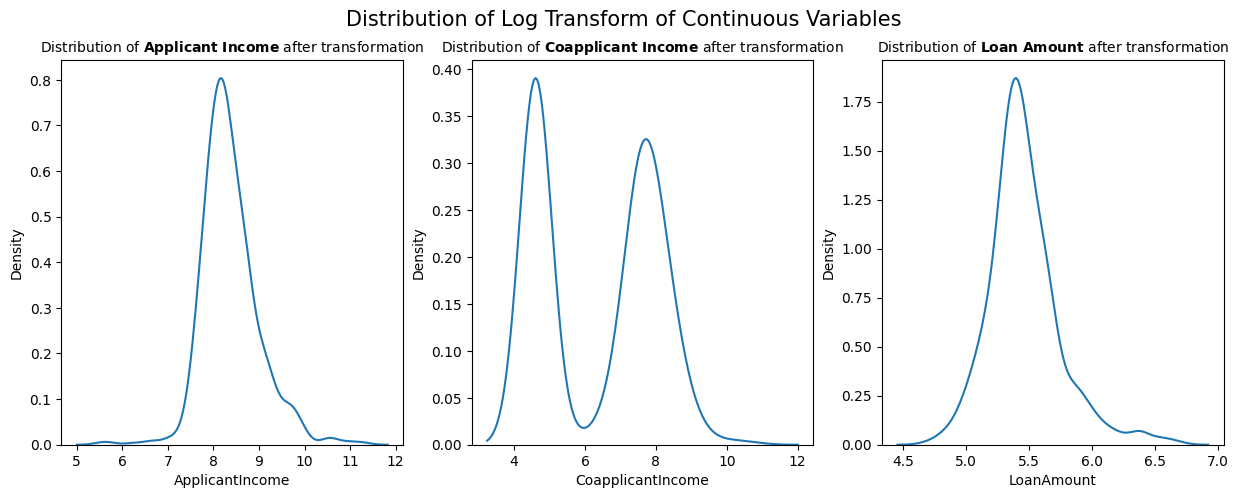

In [51]:

custom_palette = ['#4CAF50', '#FF5722']  # 'A': '#7FD4C1', 'B': '#30BFDD', 'C': '#8690FF', 'E': '#F7C0BB'

fig, ax = plt.subplots(1, 3, figsize=(15,5 ))
fig.suptitle("Distribution of Log Transform of Continuous Variables", fontsize=15)

for i, feature in enumerate(num_vars):
    sns.kdeplot(data=np.log(df[feature]+100),ax=ax[i])
    
    feature = re.sub(r'(?<!^)(?=[A-Z])', '\\ ', feature)
    feature = feature.replace('_', ' ')
    
    ax[i].set_title(f"Distribution of $\\bf{{{feature}}}$ after transformation", fontsize=10)

# Dimentinality reduction and plot the numerical features across `Loan_Status`

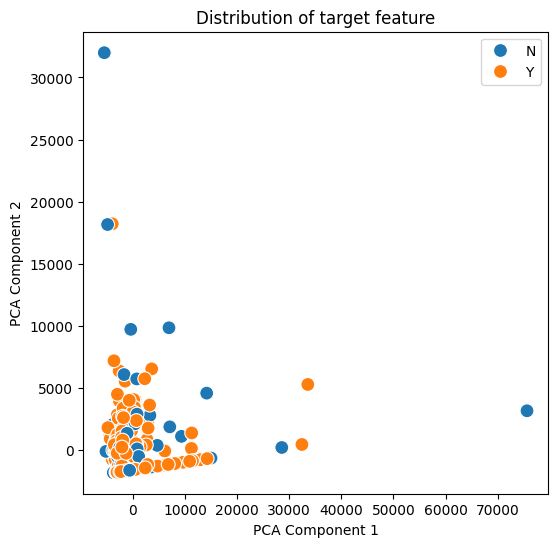

In [74]:
data = df.dropna()
X = data[num_vars]


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


plt.figure(figsize=(6, 6))

sns.scatterplot(x= X_pca[:, 0], y=X_pca[:, 1], hue= data['Loan_Status'], s = 100)

plt.title('Distribution of target feature')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


# Check Missing values

In [19]:
sum(df["Gender"].isnull())/df.shape[0]


for f in df.columns:
    print(f"Percent of missing values in {f}:", (sum(df[f].isnull())/df.shape[0])*100)

Percent of missing values in Gender: 2.1172638436482085
Percent of missing values in Married: 0.4885993485342019
Percent of missing values in Dependents: 2.44299674267101
Percent of missing values in Education: 0.0
Percent of missing values in Self_Employed: 5.211726384364821
Percent of missing values in ApplicantIncome: 0.0
Percent of missing values in CoapplicantIncome: 0.0
Percent of missing values in LoanAmount: 3.5830618892508146
Percent of missing values in Loan_Amount_Term: 9.446254071661238
Percent of missing values in Credit_History: 8.143322475570033
Percent of missing values in Property_Area: 0.0
Percent of missing values in Loan_Status: 0.0


# Pipeline and Model Training

## Load Data

In [2]:
df = pd.read_csv("loan_data_set.csv")
df.drop(columns = "Loan_ID", inplace = True)

applicant_income_percentiles = list(df["ApplicantIncome"].quantile([.25,.5,.75]) )
coapplicant_income_percentiles = list(df["CoapplicantIncome"].quantile([.25,.5,.75]) )
loan_amount_percentiles = list(df["LoanAmount"].quantile([.25,.5,.75]) )

print(applicant_income_percentiles)
print(coapplicant_income_percentiles)
print(loan_amount_percentiles)

[2877.5, 3812.5, 5795.0]
[0.0, 1188.5, 2297.25]
[100.0, 128.0, 168.0]


## Preprocess Pipeline

In the following code block, we define the preprocessing pipeline for both categorical and continuous features. The main objective is to prepare the data for machine learning models by handling missing values, binning continuous variables, applying transformations, and encoding categorical variables. We will use custom transformer classes and the `Pipeline` and `ColumnTransformer` tools from scikit-learn.

**Description of the Code:**

*Feature Sets:*

- cat_features: A list of categorical features in the dataset
- cont_features_for_binning: List of continuous features that will be binned into discrete categories
- cont_features: List of continuous features 

*Classes:*

- Preprocess: is a base class that implements fit and transform methods, which is inherited by other custom transformer classes. The fit method doesn't modify the data, while the transform method is meant to be overridden in the subclasses for specific data transformation tasks.

- TransformLoanTerm: This transformer replaces values in the `Loan_Amount_Term1 column with predefined categories. It converts specific loan terms into discrete values ranging from 0 to 4, which simplifies the original numerical variable.

- ApplicantIncomeBinning: This transformer bins the `ApplicantIncome` into four categories based on predefined income cutoffs. The column is then dropped to avoid redundancy.

- CoapplicantIncomeBinning: Similar to ApplicantIncomeBinning, this transformer bins the `CoapplicantIncome` into three categories.
LoanAmountBinning: This transformer bins 'LoanAmount' into four categories, although the actual binning function is not used in the pipeline in the provided code.

*Log Transformation Function (log100p):*

The function log100p(x) applies a logarithmic transformation to continuos features, with a small shift (adding 100) to prevent taking the log of zero.


*Categorical Transformer Pipeline (cat_transformer):*

The categorical features undergo the following transformations:
- Binning: Continuous variables like `ApplicantIncome` and `CoapplicantIncome` are binned into categories.
- Imputation: Missing values are handled by replacing them with the most frequent value in the respective column.
- Encoding: The categorical features are encoded using OrdinalEncoder to convert them into numeric representations, with handling for unknown values.

*Continuous Transformer Pipeline (cont_transformer):*

The continuous features are processed through:
- Imputation: Missing values are filled with the mean of each column.
- Log Transformation: A log transformation is applied to continuous features to make them more suitable for modeling. Note that we used Standard Scalar transformation and found out the log transformation returns better scores.

*Column Transformer (preprocessor):)

The ColumnTransformer combines both the categorical and continuous transformers, applying them to the respective columns based on the feature sets defined earlier. The categorical features undergo the `cat_transformer` pipeline, while the continuous features are processed with the `cont_transformer` pipeline.




In [3]:
# Define the categorical and continuous feature sets
cat_features= ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term',  'Credit_History', 'Education', 'Property_Area', ]
cont_features_for_binnig = [ 'ApplicantIncome', 'CoapplicantIncome']

cont_features = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome']

class Preprocess(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None):
        return self
        

    def transform(self, X=None):
        return self
    

def log100p(x):
    return np.log(100+x)


class TransformLoanTerm(Preprocess):
    def transform(self, X = None):
        X['Loan_Amount_Term'] = X['Loan_Amount_Term'].replace({
        12: 0,  
        36: 0,    
        60: 0,
        84: 0,   
        120:0,
        180: 1,
        240: 2,
        300: 2,
        360:3,
        480: 4,
        np.nan: np.nan
        })
        return X



class ApplicantIncomeBinning(Preprocess):
    def transform(self, X = None):
        cut_values = [0 ,2877.5, 3812.5, 5795.0, np.inf] #[0]+ list(df["ApplicantIncome"].quantile([.25,.5,.75]) ) +[np.inf], needs to get updated after changing the dataset
        #print(cut_values)
        labels = [0,1,2,3]
        X["ApplicantIncomeBinning"] = pd.cut(X["ApplicantIncome"], bins = cut_values, labels = labels, ordered = True)
        X = X.drop(columns = ["ApplicantIncome"])
        return X
    
class CoapplicantIncomeBinnig(Preprocess):
    def transform(self, X = None):
        cut_values = [0.0, 1188.5, 2297.25, np.inf] #list(df["CoapplicantIncome"].quantile([.25,.5,.75]) )+ [np.inf] # update this part after updating the dataset
        labels = [0,1,2]
        X["CoapplicantIncomeBinning"] = pd.cut(X["CoapplicantIncome"], bins = cut_values, labels = labels, ordered = True)
        X = X.drop(columns = ["CoapplicantIncome"])
        return X
    
class LoanAmountBinnig(Preprocess):
    def transform(self, X = None):
        cut_values = [0, 100.0, 128.0, 168.0, np.inf] #[0]+ list(df["LoanAmount"].quantile([.25,.5,.75]) )+ [np.inf] # update this part after updating the dataset
        labels = [0,1,2,3]
        X["LoanAmountBinning"] = pd.cut(X["LoanAmount"], bins = cut_values, labels = labels, ordered = True)
        X = X.drop(columns = ["LoanAmount"])
        return X
    


X = df.drop(columns = ["Loan_Status"])
y = df['Loan_Status']
y_mapped = y.map({'Y': 1, 'N': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, stratify= y, train_size = .8)
# print(len(X_train), len(y_train))
# print(len(X_test), len(y_test))

cat_transformer = Pipeline(steps=[
    ('loan_term_transformer', TransformLoanTerm()),
    #('loan_amount_binnig', LoanAmountBinnig()), #Binning the LoanAmount 
    ('applicant_income_binning', ApplicantIncomeBinning()), #Binning the AplicantIncome 
    ('coapplicant_income_binning', CoapplicantIncomeBinnig()), #Binning the CoapplianctIncome
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OrdinalEncoder(handle_unknown= "use_encoded_value", unknown_value= -1))
])

cont_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing continuous values
    ('log_transform', FunctionTransformer(log100p)),
    #('scaler', StandardScaler())  # Standard scaling for continuous features
])

# Combine both categorical and continuous transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_features + cont_features_for_binnig),
    ('cont', cont_transformer, cont_features)
])



preprocessor


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('loan_term_transformer',
                                                  TransformLoanTerm()),
                                                 ('applicant_income_binning',
                                                  ApplicantIncomeBinning()),
                                                 ('coapplicant_income_binning',
                                                  CoapplicantIncomeBinnig()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Gender', 'Married', 'Dependents',
                                  'Self_Employed', 'Loan_Amount_Term',
                                  'Credit_History', 'Education',
                                  'Property_Area', 'ApplicantIncome',
                                  'CoapplicantIncome']),
                                ('cont',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<function log100p at 0x000001525A4B7010>))]),
                                 ['LoanAmount', 'ApplicantIncome',
                                  'CoapplicantIncome'])])

In [4]:
# Check preprocess pipelipeline
#loan_term_transformer.fit_transform(X_train)
#applicant_income_transformer.fit_transform(X_train)

In [5]:
preprocessor.fit_transform(X_train)

array([[1.        , 1.        , 0.        , ..., 5.55295958, 8.48838211,
        4.60517019],
       [1.        , 0.        , 0.        , ..., 5.98141421, 8.70632484,
        8.37378461],
       [1.        , 1.        , 0.        , ..., 5.04985601, 8.03915739,
        8.16507926],
       ...,
       [1.        , 1.        , 0.        , ..., 5.37063803, 8.3635757 ,
        4.60517019],
       [1.        , 1.        , 0.        , ..., 5.50843125, 7.82404601,
        8.26873183],
       [0.        , 1.        , 0.        , ..., 5.29831737, 7.61480536,
        7.4639366 ]])

In [6]:
# Check Preprocess pipeline
cont_features_binned = ["ApplicantIncomeBinning" ,"CoapplicantIncomeBinning"]
new_feature_names = cat_features+cont_features_binned+cont_features
transformed_df = pd.DataFrame(preprocessor.fit_transform(X_train), columns=new_feature_names)

# Display the transformed DataFrame
transformed_df.head()

,Gender,Married,Dependents,Self_Employed,Loan_Amount_Term,Credit_History,Education,Property_Area,ApplicantIncomeBinning,CoapplicantIncomeBinning,LoanAmount,ApplicantIncome,CoapplicantIncome
0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0,2.0,2.0,5.552960,8.488382,4.605170
1,1.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,3.0,2.0,5.981414,8.706325,8.373785
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,5.049856,8.039157,8.165079
3,1.0,1.0,0.0,0.0,3.0,1.0,1.0,2.0,0.0,1.0,5.273000,7.796880,7.387709
4,1.0,1.0,0.0,0.0,3.0,0.0,1.0,2.0,3.0,2.0,5.318120,8.956738,4.605170


## Defining Performance function to check the classification metric

In [7]:
def performance(model):

    train_performance = []
    test_performance = []
    metrics_list = [accuracy_score,precision_score, recall_score, f1_score ]
    for m in metrics_list:
        try:
            train_performance.append(m(y_train,model.predict(X_train), pos_label= 0))
            test_performance.append(m(y_test, model.predict(X_test), pos_label= 0))
        except:
            train_performance.append(m(y_train,model.predict(X_train)))
            test_performance.append(m(y_test, model.predict(X_test)))

    
    performance_df = pd.DataFrame([train_performance,test_performance], columns=['accuracy', 'precision', 'recall', 'f1'], index= ['trian','test'])
    display(performance_df)

    #confusion matrix:

    fig, ax = plt.subplots(1,2,figsize = (12,5))

    cm_train_display = ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax= ax[0])#display_labels = [False, True])
    ax[0].set_title("Trian")

    cm_test_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax = ax[1] )#display_labels = [False, True])
    ax[1].set_title("Test")

    cm_train_display.confusion_matrix
    cm_test_display.confusion_matrix
    plt.show()

## Model Training

### Logestic Regression

,accuracy,precision,recall,f1
trian,0.786151,0.728972,0.506494,0.597701
test,0.813008,0.777778,0.552632,0.646154


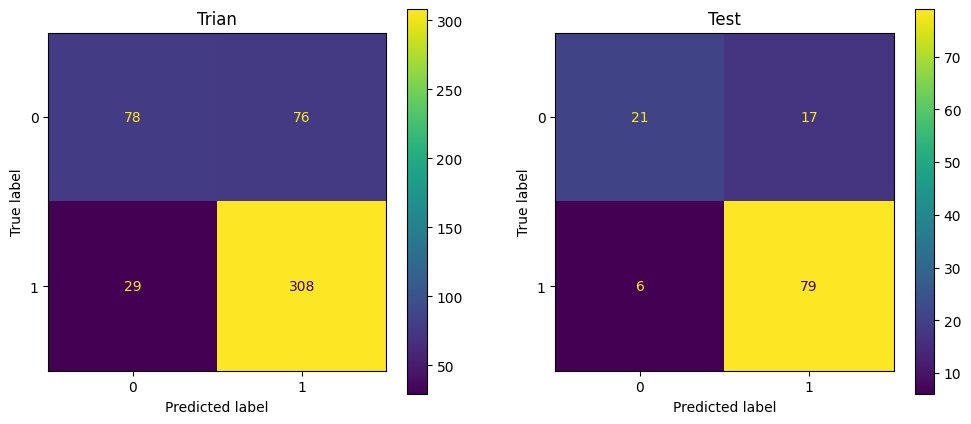

In [8]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    ('smote', SMOTE()),  # Handle imbalanced classes using SMOTE
    ('classifier', LogisticRegression())  # Logistic Regression model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

performance(pipeline)


In [9]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('loan_term_transformer',
                                                                   TransformLoanTerm()),
                                                                  ('applicant_income_binning',
                                                                   ApplicantIncomeBinning()),
                                                                  ('coapplicant_income_binning',
                                                                   CoapplicantIncomeBinnig()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_...
                                                   'Loan_Amount_Term',
                                                   'Credit_History',
                                                   'Education', 'Property_Area',
                                                   'ApplicantIncome',
                                                   'CoapplicantIncome']),
                                                 ('cont',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log100p at 0x000001525A4B7010>))]),
                                                  ['LoanAmount',
                                                   'ApplicantIncome',
                                                   'CoapplicantIncome'])])),
                ('smote', SMOTE()), ('classifier', LogisticRegression())])

### SVM

,accuracy,precision,recall,f1
trian,0.804481,0.926471,0.409091,0.567568
test,0.837398,0.909091,0.526316,0.666667


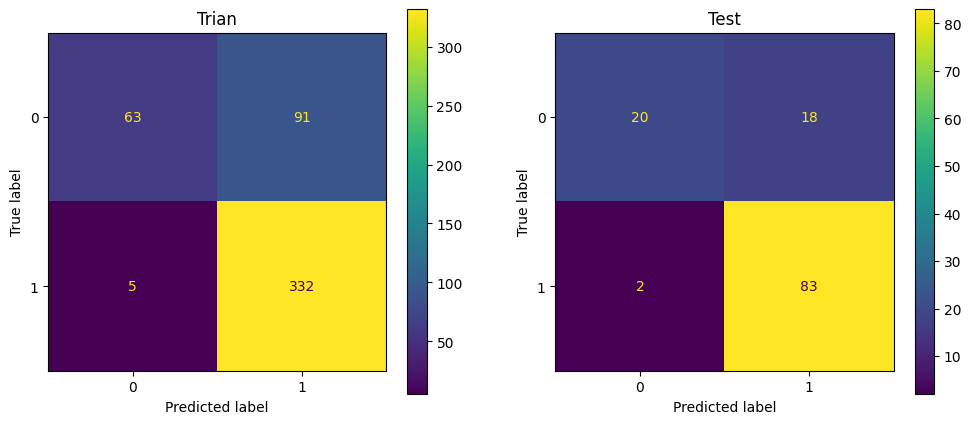

In [10]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    ('smote', SMOTE()),  # Handle imbalanced classes using SMOTE
    ('classifier', SVC(kernel = 'poly', degree =3)) 
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

performance(pipeline)

Best parameters found:  {'classifier__degree': 6, 'classifier__kernel': 'poly'}
Best cross-validation score: 0.5489


c:\Users\solmaz\anaconda3\envs\BigData\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,accuracy,precision,recall,f1
trian,0.804481,0.730159,0.597403,0.657143
test,0.813008,0.727273,0.631579,0.676056


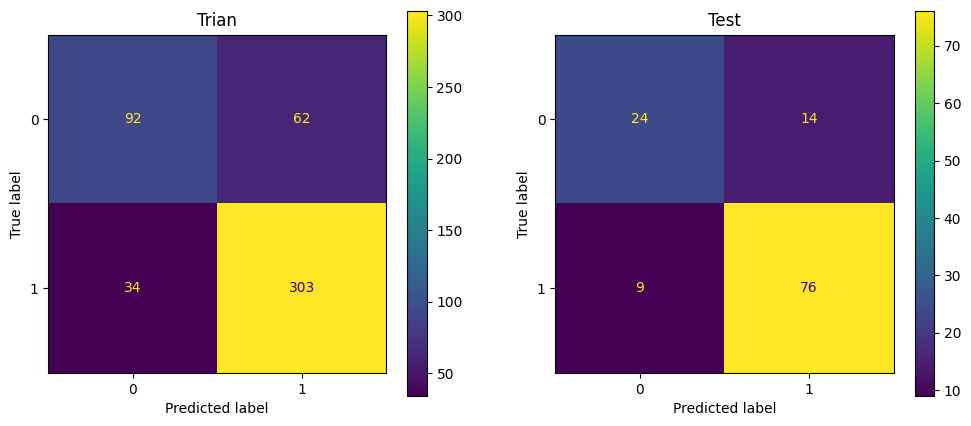

In [11]:
# Hyper parameter tunning for SVM

custome_f1_score = make_scorer(f1_score, pos_label = 0)


param_grid = {
    'classifier__kernel': ['rbf','poly', 'sigmoid'],
    'classifier__degree': [3,5,6,7,9]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    ('smote', SMOTE()),  # Uncomment if needed for handling imbalanced classes
    ('classifier', SVC())  # You will tune the hyperparameters via GridSearchCV
])

# Set up the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring=custome_f1_score, n_jobs=-1)

# Fit the grid search model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Use the best estimator to evaluate the performance on test data
best_pipeline = grid_search.best_estimator_
performance(best_pipeline)

### Linear Discriminate Analysis

,accuracy,precision,recall,f1
trian,0.798371,0.831325,0.448052,0.582278
test,0.813008,0.800000,0.526316,0.634921


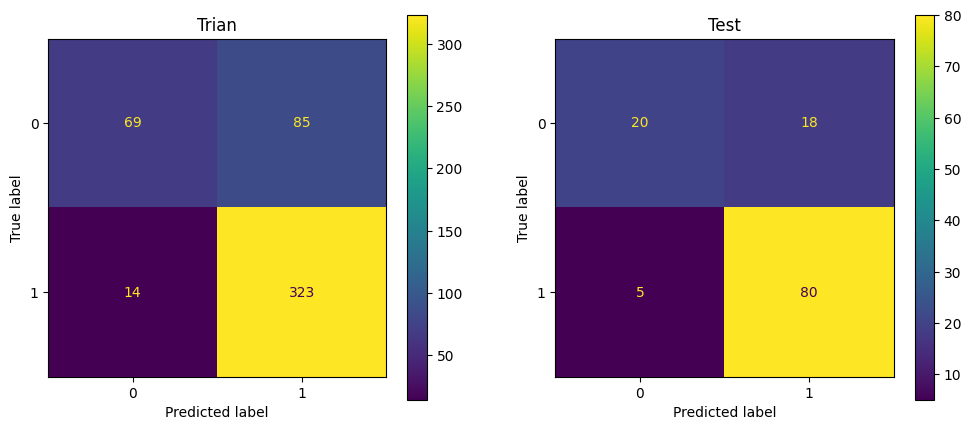

In [12]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    ('smote', SMOTE()),  # Handle imbalanced classes using SMOTE
    ('classifier', LinearDiscriminantAnalysis(n_components=1)) 
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

performance(pipeline)

In [19]:
# Check the mean f1-score using cross_validation technique
custome_f1_score = make_scorer(f1_score, pos_label = 0)

f1_scores_cross_val = cross_val_score(pipeline, X_train, y_train, cv =10, scoring = custome_f1_score)

print(f"F1 scores across 10 folds: {f1_scores_cross_val}")
print(f"Mean F1 score: {f1_scores_cross_val.mean()}")

F1 scores across 10 folds: [0.51612903 0.28571429 0.6        0.59259259 0.625      0.64
 0.36363636 0.71428571 0.46666667 0.59259259]
Mean F1 score: 0.539661724774628


### Random Forest Classifier

c:\Users\solmaz\anaconda3\envs\BigData\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'classifier__class_weight': {0: 2.19, 1: 1}, 'classifier__max_depth': 8, 'classifier__max_leaf_nodes': 10, 'classifier__n_estimators': 500}
Best cross-validation score: 0.5724


,accuracy,precision,recall,f1
trian,0.837067,0.920455,0.525974,0.669421
test,0.837398,0.875000,0.552632,0.677419


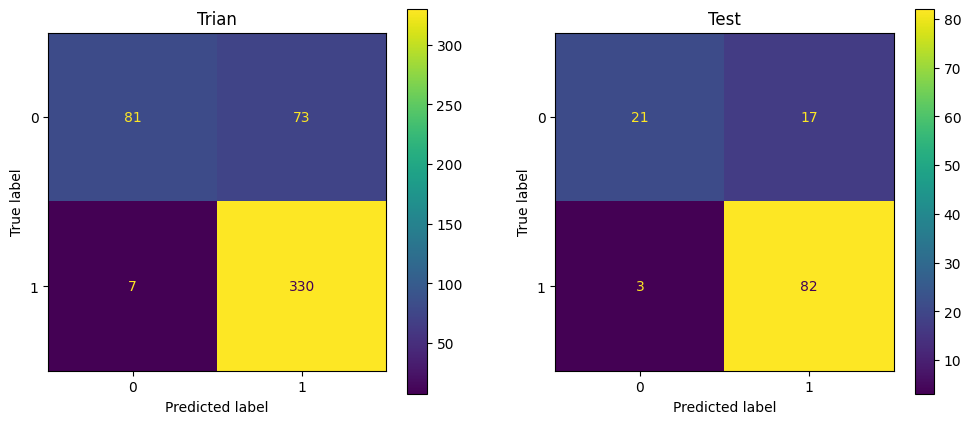

In [14]:
custome_f1_score = make_scorer(f1_score, pos_label = 0)

param_grid = {
    'classifier__n_estimators': [500,1000,1500],
    'classifier__max_depth': [8,9,10,11],                   # Max depth of trees
    'classifier__max_leaf_nodes': [8,9,10, 11],              # Max leaf nodes
    'classifier__class_weight': [{0: 2, 1: 1},{0: 2.19, 1: 1}, {0: 3, 1: 1},]  # Class weights
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor
    #('smote', SMOTE()),  # comment over sampling thechnique, since we can handle imbalance data using class_weight parameter
    ('classifier', RandomForestClassifier())  #get the parameteres from param_grid
])

# Set up the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=custome_f1_score, n_jobs=-1, error_score='raise')

# Fit the grid search model to the training data
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Use the best estimator to evaluate the performance
best_pipeline = grid_search.best_estimator_
performance(best_pipeline)


In [15]:
# Finding the importance of features 
classifier = best_pipeline.named_steps['classifier']

# Get feature importances
importances = classifier.feature_importances_

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': new_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the most important features
print(feature_importance_df)


                     Feature  Importance
5             Credit_History    0.460800
11           ApplicantIncome    0.124827
10                LoanAmount    0.116690
12         CoapplicantIncome    0.079210
4           Loan_Amount_Term    0.047617
7              Property_Area    0.041142
9   CoapplicantIncomeBinning    0.033088
2                 Dependents    0.021865
1                    Married    0.019819
8     ApplicantIncomeBinning    0.019793
6                  Education    0.017854
3              Self_Employed    0.010097
0                     Gender    0.007198


### KNN Classifier


,accuracy,precision,recall,f1
trian,0.767821,0.602041,0.766234,0.674286
test,0.666667,0.468085,0.578947,0.517647


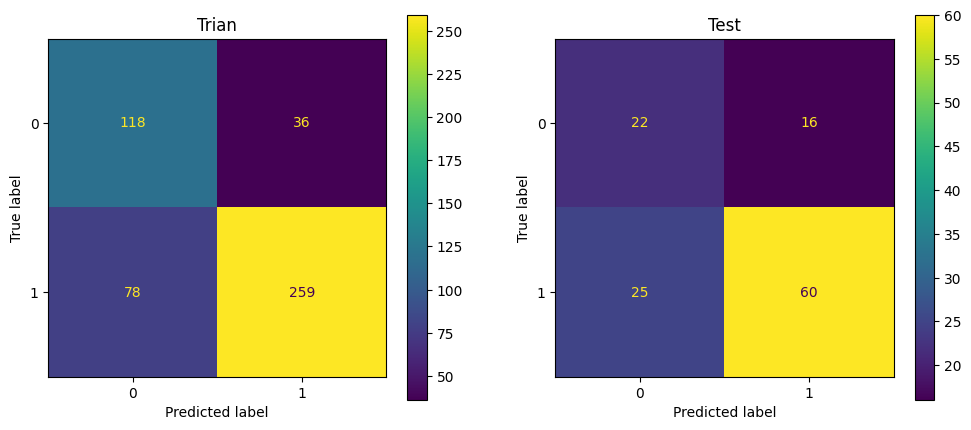

In [16]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    ('smote', SMOTE()),  # Handle imbalanced classes using SMOTE
    ('classifier', KNeighborsClassifier(n_neighbors=7) )
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

performance(pipeline)

### XGBoost

,accuracy,precision,recall,f1
trian,0.851324,0.681614,0.987013,0.806366
test,0.723577,0.534483,0.815789,0.645833


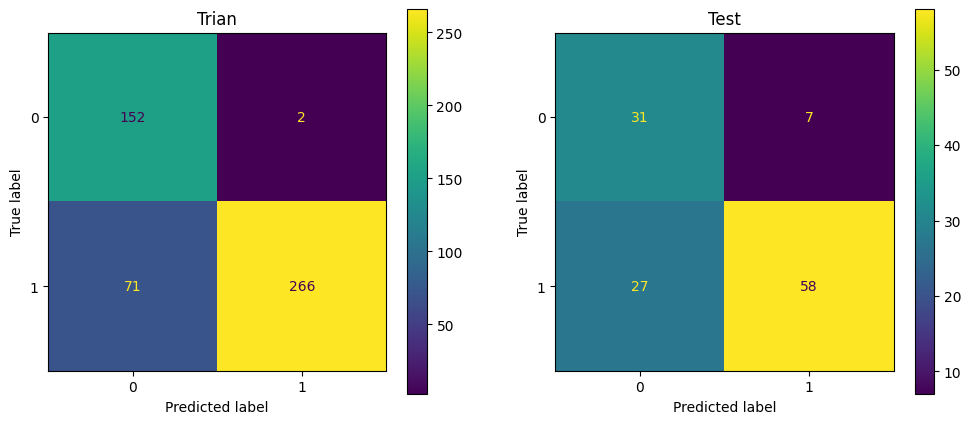

In [17]:
params = {
    'n_estimators': 100,
    'objective':'binary:logistic',
    'max_depth' : 4,
    'scale_pos_weight':.2,  # If not using SMOTE
    'eval_metric':'logloss', # Use logloss for binary classification
    'eta': 0.11 ,
    'subsample': .8,

}

pipeline = Pipeline(steps= [
    ('preprocessor', preprocessor),
    #('smote', SMOTE()),
    ('classifier', XGBClassifier(**params))
])

pipeline.fit(X_train, y_train)

performance(pipeline)

c:\Users\solmaz\anaconda3\envs\BigData\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'classifier__eta': 0.11, 'classifier__eval_metric': 'logloss', 'classifier__max_depth': 4, 'classifier__n_estimators': 150, 'classifier__objective': 'binary:logistic', 'classifier__scale_pos_weight': 0.18, 'classifier__subsample': 0.85}


,accuracy,precision,recall,f1
trian,0.837067,0.920455,0.525974,0.669421
test,0.837398,0.875000,0.552632,0.677419


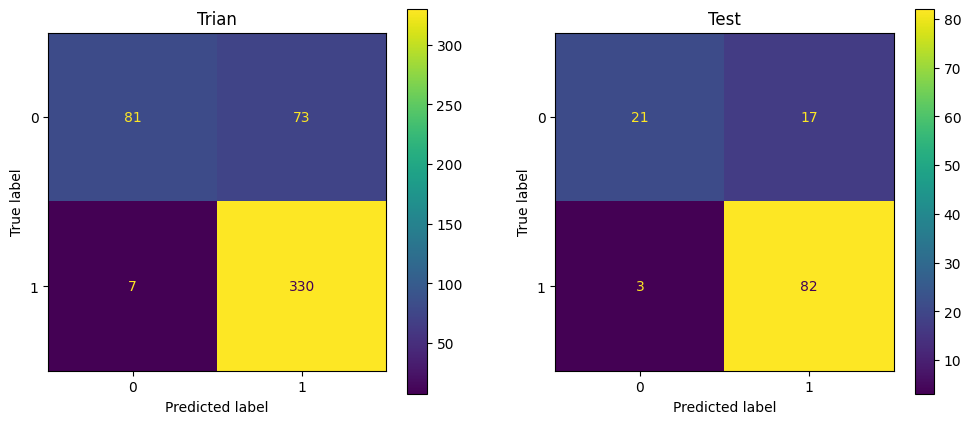

In [18]:
# Hyperparameter tunning
custome_f1_score = make_scorer(f1_score, pos_label = 0)
param_grid = {
    'classifier__n_estimators': [80, 100, 150, 200],
    'classifier__objective':['binary:logistic'],
    'classifier__max_depth' : [3,4,5],
    'classifier__scale_pos_weight':[.18,.19, .2, 2.1],  # If not using SMOTE
    'classifier__eval_metric':['logloss'], # Use logloss for binary classification
    'classifier__eta': [.1, 0.11] ,
    'classifier__subsample': [.75,.8, .85],
}

pipeline = Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

    
grid_search = GridSearchCV(pipeline, param_grid, cv =10, scoring =custome_f1_score, n_jobs=-1 , error_score='raise')

grid_search.fit(X_train, y_train)

best_params= grid_search.best_params_
print(best_params)

performance(best_pipeline)